In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sst
from scipy.stats import norm
import yfinance as yf
import statsmodels.api as sm
from datetime import datetime

import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm

기준일 직전 6개월 실현변동성과 옵션 주기둥안의 실현변동성을 비교한 표도 포함할 것

----------------- Final Term 2번 ---------------------------

[조건]
1. 기준일 직전 6개월 SMA 변동성이 30% 내외인 종목 수개 선정(최소 4개)
2. 10% OTM E_V_Call을 일정한 마진을 확보한 상태에서 10만개 기준으로 매수/매도.
3. Margin은 변동성에 비례하여 15% 가감함
4. 30% 변동성이라면 매수는 25.5% 매도는 34.5%의 내재변동성으로 옵션 프리미엄 산출
5. 거래비용은 매도시 매도대금의 0.1% / 자금비용은 연 4%로 해서 일별 계산함

In [2]:
r = 0.04
q = 0


In [3]:
# Black-Scholes 가격 계산 함수
def bsprice(S, X, r, q, t, imvol, flag):
    d1 = (np.log(S / X) + (r - q + 0.5 * imvol ** 2) * t) / (imvol * np.sqrt(t))
    d2 = d1 - imvol * np.sqrt(t)
    callOrPut = 1 if flag.lower() == 'call' else -1
    nd1 = norm.cdf(callOrPut * d1)
    nd2 = norm.cdf(callOrPut * d2)
    price = callOrPut * (S * np.exp(-q * t) * nd1 - X * np.exp(-r * t) * nd2)
    return price

# Delta 계산 함수
def delta(S, X, r, q, t, sigma, flag):
    d1 = (np.log(S / X) + (r - q + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    return norm.cdf(d1) if flag.lower() == 'call' else norm.cdf(d1) - 1

# 동적 헤징 시뮬레이션 함수
def dynamic_hedging_simulation_updated(unique_trade_data, X, r, q, T, shares_per_call, flag):
    """
    주어진 주가 경로를 기반으로 동적 헤징 시뮬레이션을 수행합니다.
    """
    # Extract relevant columns
    S_paths = unique_trade_data['udly_close'].values
    sigma_paths = unique_trade_data['trade_imvol'].values
    t_paths = unique_trade_data['trade_remaindays'].values

    m = len(S_paths)  # 거래일 수 (주어진 S_paths 길이)

    # 시간 계산 (각각의 경로에 대한 잔여 시간)
    time_to_maturity = T - np.arange(m) * (T / m)
    time_to_maturity = np.maximum(0, time_to_maturity)  # 음수 방지

    # 델타 계산 (각 경로의 각 시점에 대해 계산)
    deltas = np.array([delta(S_paths[i], X, r, q, time_to_maturity[i], sigma_paths[i], flag) for i in range(m)])

    # 델타 차이 계산 및 주식 매수/매도
    delta_diff = np.diff(np.hstack((np.zeros(1), deltas)), axis=0)  # np.zeros(1)로 수정
    shares_purchased = delta_diff * shares_per_call  # 주식 매수/매도

    # 주식 매수/매도 비용 계산
    cost_of_shares = shares_purchased * S_paths

    # 거래 비용 계산 (매도 시 0.1% 비용)
    transaction_costs = np.where(cost_of_shares < 0, np.abs(cost_of_shares) * 0.001, 0)

    # 누적 비용 계산
    cumulative_costs = np.cumsum(cost_of_shares)

    # 이자 비용 추가 (누적 비용에 대한 이자)
    interest_costs = np.zeros_like(cumulative_costs)
    interest_costs[:-1] = cumulative_costs[:-1] * (np.exp(r * (T / m)) - 1)
    cumulative_costs[1:] += interest_costs[1:]

    # 최종 헤징 비용 계산
    final_cost = cumulative_costs[-1]
    hedge_cost = np.where(S_paths[-1] > X, final_cost - X * shares_per_call, final_cost)
    hedge_cost_with_transaction = hedge_cost + np.sum(transaction_costs)

    # 이론적 가격 (Black-Scholes 옵션 가격 계산)
    theoretical_price = bsprice(S_paths[0], X, r, q, T, sigma_paths[0]*1.15, flag) * shares_per_call

    # PnL 계산
    pnl = theoretical_price - hedge_cost_with_transaction

    # ATM, OTM, ITM 상태 구분
    atm_case = S_paths[-1] >= 0.99 * X and S_paths[-1] <= 1.01 * X
    itm_case = S_paths[-1] > X
    otm_case = S_paths[-1] < X

    # BS Price 변화량 계산 (변화량은 가격 차이)
    bs_price_changes = np.array([bsprice(S_paths[i], X, r, q, time_to_maturity[i], sigma_paths[i], flag) for i in range(m)])
    bs_price_diff = np.diff(bs_price_changes)  # 각 시점의 가격 차이

    # 델타 * 주가 변화량 계산 (델타 변화량 * 주가 변화량)
    delta_diff_price = np.diff(deltas) * np.diff(S_paths)  # 델타 차이 * 주가 차이
    # 표준편차 계산
    performance_std = np.std(bs_price_diff-delta_diff_price)
    error = np.mean(bs_price_diff-delta_diff_price)

    # 결과를 DataFrame으로 반환
    df_results = pd.DataFrame({
        "Final Stock Price": [S_paths[-1].round(2)],
        "Strike Price" : [int(otm_strike)],
        "Theoretical Price": [theoretical_price.round(2)],
        "Hedging Cost": [hedge_cost_with_transaction.round(2)],
        "PnL": [pnl.round(2)],
        "ATM Case": [atm_case],
        "ITM Case": [itm_case],
        "OTM Case": [otm_case],
        "Performance": [performance_std.round(2)],
        "Cumulative_error" : [error.round(2)]
    })

    return df_results


In [4]:
from pathlib import Path

CWD_PATH = Path.cwd()
WS_PATH  = CWD_PATH.parent
DATA_PATH = WS_PATH / 'data'
OUTPUT_PATH = WS_PATH / 'output'

In [6]:
data = pd.read_parquet(OUTPUT_PATH / 'option_data_targets_20220101-20241204.parquet')
data['im_vol'] = data['im_vol'] / 100

data

,underlying_full,ticker,trade_date,expiration,expiration_date,call_or_put,strike,close_price,open_price,high_price,...,udly_low,udly_close,udly_volume,udly_return,ret_vol_120d_ann,close_strike_diff,atm,itm,otm,moneyness
154,KT,030200,2022-01-03,202201,2022-01-13,C,30000.0,800.0,810.0,870.0,...,30250,30350,1027133,-0.008170,NaN,350.0,True,False,False,-0.011599
155,KT,030200,2022-01-03,202201,2022-01-13,C,31000.0,330.0,310.0,330.0,...,30250,30350,1027133,-0.008170,NaN,-650.0,False,False,True,0.021191
156,KT,030200,2022-01-03,202201,2022-01-13,C,32000.0,100.0,100.0,110.0,...,30250,30350,1027133,-0.008170,NaN,-1650.0,False,False,True,0.052939
157,KT,030200,2022-01-03,202201,2022-01-13,C,33000.0,50.0,40.0,110.0,...,30250,30350,1027133,-0.008170,NaN,-2650.0,False,False,True,0.083711
158,KT,030200,2022-01-03,202201,2022-01-13,C,34000.0,60.0,40.0,70.0,...,30250,30350,1027133,-0.008170,NaN,-3650.0,False,False,True,0.113564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5668711,현대제철,004020,2024-12-04,202412,2024-12-12,P,19500.0,100.0,90.0,120.0,...,20850,21450,664736,-0.016055,0.326276,1950.0,False,False,True,-0.095310
5668712,현대제철,004020,2024-12-04,202412,2024-12-12,P,20000.0,160.0,160.0,160.0,...,20850,21450,664736,-0.016055,0.326276,1450.0,False,False,True,-0.069992
5668713,현대제철,004020,2024-12-04,202412,2024-12-12,P,21000.0,430.0,490.0,540.0,...,20850,21450,664736,-0.016055,0.326276,450.0,True,False,False,-0.021202
5668714,현대제철,004020,2024-12-04,202412,2024-12-12,P,22000.0,950.0,1060.0,1240.0,...,20850,21450,664736,-0.016055,0.326276,-550.0,False,True,False,0.025318


In [7]:
samsung_data = data[data['underlying_full'] == '삼성전자']

# Display the filtered data
samsung_data.shape


(10606, 28)

In [8]:
def calculate_time_to_maturity(data):
    # "expiration"과 "trade_date" 열이 존재하는지 확인
    if 'expiration' not in data.columns or 'trade_date' not in data.columns:
        raise KeyError("Columns 'expiration' or 'trade_date' not found in the dataset.")

    # 만기를 Date 형식으로 변환
    data['expiration_date'] = pd.to_datetime(data['expiration_date'], errors='coerce')
    
    # 거래일을 Date 형식으로 변환
    data['trade_date'] = pd.to_datetime(data['trade_date'], errors='coerce')
    
    # Time to Maturity 계산
    data['time_to_maturity'] = ((data['expiration_date'] - data['trade_date']).dt.days) /365

    # 만기와 거래일이 같은 달에 속하는 데이터 제거
    data = data[data['time_to_maturity'] > 0]

    return data

# 수정된 함수를 데이터에 적용
samsung_data = calculate_time_to_maturity(samsung_data)

# 결과 확인
samsung_data

,underlying_full,ticker,trade_date,expiration,expiration_date,call_or_put,strike,close_price,open_price,high_price,...,udly_close,udly_volume,udly_return,ret_vol_120d_ann,close_strike_diff,atm,itm,otm,moneyness,time_to_maturity
3025,삼성전자,005930,2022-01-03,202201,2022-01-13,C,76000.0,3100.0,3100.0,3100.0,...,78600,13502112,0.003831,NaN,2600.0,False,True,False,-0.033638,0.027397
3026,삼성전자,005930,2022-01-03,202201,2022-01-13,C,78000.0,1580.0,1960.0,2400.0,...,78600,13502112,0.003831,NaN,600.0,True,False,False,-0.007663,0.027397
3027,삼성전자,005930,2022-01-03,202201,2022-01-13,C,80000.0,690.0,830.0,1220.0,...,78600,13502112,0.003831,NaN,-1400.0,False,False,True,0.017655,0.027397
3028,삼성전자,005930,2022-01-03,202201,2022-01-13,C,82000.0,310.0,480.0,540.0,...,78600,13502112,0.003831,NaN,-3400.0,False,False,True,0.042348,0.027397
3030,삼성전자,005930,2022-01-03,202201,2022-01-13,C,86000.0,130.0,140.0,140.0,...,78600,13502112,0.003831,NaN,-7400.0,False,False,True,0.089976,0.027397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5664708,삼성전자,005930,2024-12-04,202412,2024-12-12,P,56000.0,3400.0,3150.0,3450.0,...,53100,29004766,-0.009328,0.365563,-2900.0,False,True,False,0.053175,0.021918
5664709,삼성전자,005930,2024-12-04,202412,2024-12-12,P,58000.0,5000.0,4950.0,5000.0,...,53100,29004766,-0.009328,0.365563,-4900.0,False,True,False,0.088266,0.021918
5664725,삼성전자,005930,2024-12-04,202501,2025-01-09,P,45000.0,220.0,220.0,220.0,...,53100,29004766,-0.009328,0.365563,8100.0,False,False,True,-0.165514,0.098630
5664731,삼성전자,005930,2024-12-04,202501,2025-01-09,P,52000.0,1680.0,1800.0,1800.0,...,53100,29004766,-0.009328,0.365563,1100.0,False,False,True,-0.020933,0.098630


In [9]:
r = 0.04
dividend_yield = 0

In [10]:
# Greeks 계산 함수 정의
def bs_delta(S, X, r, q, t, sigma, option_type):
    """BSM Delta 계산"""
    d1 = (np.log(S / X) + (r - q + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    if option_type == 'C':
        return np.exp(-q * t) * norm.cdf(d1)
    else:
        return np.exp(-q * t) * (norm.cdf(d1) - 1)

def bs_gamma(S, X, r, q, t, sigma):
    """BSM Gamma 계산"""
    d1 = (np.log(S / X) + (r - q + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    return (np.exp(-q * t) * norm.pdf(d1)) / (S * sigma * np.sqrt(t))

def bs_vega(S, X, r, q, t, sigma):
    """BSM Vega 계산"""
    d1 = (np.log(S / X) + (r - q + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    return S * np.exp(-q * t) * norm.pdf(d1) * np.sqrt(t)

# Greeks를 데이터셋에 추가
samsung_data['delta'] = samsung_data.apply(
    lambda row: bs_delta(row['udly_close'], row['strike'], r, 
                         dividend_yield, row['time_to_maturity'], 
                         row['im_vol'], row['call_or_put']), axis=1)

samsung_data['gamma'] = samsung_data.apply(
    lambda row: bs_gamma(row['udly_close'], row['strike'], r, 
                         dividend_yield, row['time_to_maturity'], 
                         row['im_vol']), axis=1)

samsung_data['vega'] = samsung_data.apply(
    lambda row: bs_vega(row['udly_close'], row['strike'], r, 
                        dividend_yield, row['time_to_maturity'], 
                        row['im_vol']), axis=1)

# 결과 확인
samsung_data



,underlying_full,ticker,trade_date,expiration,expiration_date,call_or_put,strike,close_price,open_price,high_price,...,ret_vol_120d_ann,close_strike_diff,atm,itm,otm,moneyness,time_to_maturity,delta,gamma,vega
3025,삼성전자,005930,2022-01-03,202201,2022-01-13,C,76000.0,3100.0,3100.0,3100.0,...,NaN,2600.0,False,True,False,-0.033638,0.027397,0.865044,0.000086,2824.067109
3026,삼성전자,005930,2022-01-03,202201,2022-01-13,C,78000.0,1580.0,1960.0,2400.0,...,NaN,600.0,True,False,False,-0.007663,0.027397,0.599077,0.000130,5029.331127
3027,삼성전자,005930,2022-01-03,202201,2022-01-13,C,80000.0,690.0,830.0,1220.0,...,NaN,-1400.0,False,False,True,0.017655,0.027397,0.338006,0.000123,4756.213651
3028,삼성전자,005930,2022-01-03,202201,2022-01-13,C,82000.0,310.0,480.0,540.0,...,NaN,-3400.0,False,False,True,0.042348,0.027397,0.165489,0.000076,3235.690574
3030,삼성전자,005930,2022-01-03,202201,2022-01-13,C,86000.0,130.0,140.0,140.0,...,NaN,-7400.0,False,False,True,0.089976,0.027397,0.035765,0.000021,1023.274453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5664708,삼성전자,005930,2024-12-04,202412,2024-12-12,P,56000.0,3400.0,3150.0,3450.0,...,0.365563,-2900.0,False,True,False,0.053175,0.021918,-0.865515,0.000088,1702.358495
5664709,삼성전자,005930,2024-12-04,202412,2024-12-12,P,58000.0,5000.0,4950.0,5000.0,...,0.365563,-4900.0,False,True,False,0.088266,0.021918,-0.920106,0.000046,1167.531242
5664725,삼성전자,005930,2024-12-04,202501,2025-01-09,P,45000.0,220.0,220.0,220.0,...,0.365563,8100.0,False,False,True,-0.165514,0.098630,-0.071396,0.000021,2273.325610
5664731,삼성전자,005930,2024-12-04,202501,2025-01-09,P,52000.0,1680.0,1800.0,1800.0,...,0.365563,1100.0,False,False,True,-0.020933,0.098630,-0.380735,0.000073,6353.318139


In [11]:
samsung_data.to_csv('samsung.csv')

### Dynamic Heding (ImVol)

기준1: Trade_date 기준으로 Sort하고, 해당 거래일에서 가장 원월물인 옵션 중 거래량이 가장 높은 옵션의 Imvol사용 -> trade_imvol 열 생성

In [44]:
START_DATE = '2024-05-03'

trade_dates = samsung_data.loc[START_DATE:, :]['trade_date'].unique().tolist()

In [323]:
# Step 1: Filter the data to include only 'C' options and those with 'trade_date' >= '2024-06-01'
call_data = samsung_data[samsung_data['call_or_put'] == 'C'].copy()
call_data['remain_days'] = call_data['time_to_maturity'] * 365
call_data['moneyness'] = (call_data['udly_close'] - call_data['strike']) / call_data['strike']

start_try = '2023-05-02'

start_date = pd.to_datetime(start_try)
start_date_str = start_date.strftime('%Y-%m-%d')
end_date = start_date + pd.Timedelta(days=126)
# 'trade_date'가 start_date일 때의 'undly_close' 값 가져오기
trade_strike = call_data.loc[call_data['trade_date'] == start_date, 'udly_close'].iloc[0]

call_data['trade_moneyness'] = (call_data['udly_close'] - trade_strike) / call_data['strike']
call_data['trade_remaindays'] = (end_date - call_data['trade_date']).dt.days

# 'trade_moneyness' 계산
call_data['trade_moneyness'] = (call_data['udly_close'] - call_data['strike']) / call_data['strike']

filtered_data3 = call_data[call_data['trade_date'] >= start_date]

# Step 2: Sort by 'trade_date'
filtered_dat3 = filtered_data3.sort_values(by=['trade_date'])

# Step 3: For each unique 'trade_date', find the option with the farthest 'expiration_date'
# and assign the highest 'trade_volume' 'imvol' to a new column 'trade_imvol'
def select_trade_imvol(group):
    # Find the option with the max 'trade_volume' and the farthest 'expiration_date'
    max_trade_vol_option = group.loc[group['expiration_date'].idxmax()]
    # Assign 'trade_imvol' as 'imvol' of the option with highest 'trade_volume' and farthest maturity
    group['trade_imvol'] = max_trade_vol_option['im_vol']
    return group

# Apply this function to each group of unique 'trade_date'
filtered_data3 = filtered_data3.groupby('trade_date').apply(select_trade_imvol)

# Display the updated DataFrame
filtered_data3


underlying_full  ticker trade_date expiration  \
trade_date                                                         
2023-05-02 2420125            삼성전자  005930 2023-05-02     202305   
           2420126            삼성전자  005930 2023-05-02     202305   
           2420127            삼성전자  005930 2023-05-02     202305   
           2420128            삼성전자  005930 2023-05-02     202305   
           2420129            삼성전자  005930 2023-05-02     202305   
...                            ...     ...        ...        ...   
2024-12-04 5664625            삼성전자  005930 2024-12-04     202412   
           5664626            삼성전자  005930 2024-12-04     202412   
           5664627            삼성전자  005930 2024-12-04     202412   
           5664646            삼성전자  005930 2024-12-04     202501   
           5664647            삼성전자  005930 2024-12-04     202501   

                   expiration_date call_or_put   strike  close_price  \
trade_date                                                             
2023-05-02 2420125      2023-05-11           C  62000.0       3550.0   
           2420126      2023-05-11           C  64000.0       1880.0   
           2420127      2023-05-11           C  66000.0        660.0   
           2420128      2023-05-11           C  68000.0        160.0   
           2420129      2023-05-11           C  70000.0         50.0   
...                            ...         ...      ...          ...   
2024-12-04 5664625      2024-12-12           C  58000.0        110.0   
           5664626      2024-12-12           C  60000.0         80.0   
           5664627      2024-12-12           C  62000.0         30.0   
           5664646      2025-01-09           C  50000.0       3750.0   
           5664647      2025-01-09           C  52000.0       2400.0   

                    open_price  high_price  ...    otm  moneyness  \
trade_date                                  ...                     
2023-05-02 2420125      3550.0      3550.0  ...  False   0.059677   
           2420126      2200.0      2200.0  ...  False   0.026562   
           2420127       830.0       970.0  ...  False  -0.004545   
           2420128       180.0       280.0  ...   True  -0.033824   
           2420129        40.0        80.0  ...   True  -0.061429   
...                        ...         ...  ...    ...        ...   
2024-12-04 5664625       110.0       150.0  ...   True  -0.084483   
           5664626        80.0        80.0  ...   True  -0.115000   
           5664627        40.0        60.0  ...   True  -0.143548   
           5664646      3700.0      3750.0  ...  False   0.062000   
           5664647      2600.0      2600.0  ...  False   0.021154   

                    time_to_maturity     delta         gamma          vega  \
trade_date                                                                   
2023-05-02 2420125          0.024658  1.000000  1.237351e-37  3.950888e-31   
           2420126          0.024658  0.802109  1.296347e-04  2.869888e+03   
           2420127          0.024658  0.457730  2.045338e-04  4.092638e+03   
           2420128          0.024658  0.150905  1.117778e-04  2.415083e+03   
           2420129          0.024658  0.056695  4.453241e-05  1.175461e+03   
...                              ...       ...           ...           ...   
2024-12-04 5664625          0.021918  0.072493  4.419342e-05  1.084262e+03   
           5664626          0.021918  0.043086  2.487645e-05  7.194827e+02   
           5664627          0.021918  0.018811  1.188341e-05  3.613203e+02   
           5664646          0.098630  0.736837  5.544419e-05  5.442889e+03   
           5664647          0.098630  0.618518  7.279980e-05  6.357092e+03   

                    remain_days  trade_moneyness  trade_remaindays  \
trade_date                                                           
2023-05-02 2420125          9.0         0.059677               126   
           2420126          9.0         0.026562               126   
    

기준 2: 첫 세달은 expiration date에서 가장 먼 옵션의 임볼 사용/ 나머지 3개월은 전체기간에서 moneyness(+- 0.05)와 잔존만기 (+- 5)가 비슷한 옵션 가져오기

In [324]:
import pandas as pd
# Step 1: Filter the data to include only 'C' options and those with 'trade_date' >= '2024-06-01'
call_data = samsung_data[samsung_data['call_or_put'] == 'C'].copy()
call_data['remain_days'] = call_data['time_to_maturity'] * 365
call_data['moneyness'] = (call_data['udly_close'] - call_data['strike']) / call_data['strike']


# 데이터 필터링: 'trade_date'가 start_date 이상인 데이터만 포함
filtered_data1 = call_data[call_data['trade_date'] >= start_date]

# 'trade_moneyness' 계산
trade_strike = call_data.loc[call_data['trade_date'] == start_date, 'udly_close'].iloc[0]
call_data['trade_moneyness'] = (call_data['udly_close'] - 0.9 * trade_strike) / call_data['strike']
call_data['trade_remaindays'] = (end_date - call_data['trade_date']).dt.days

# 첫 3개월 조건을 체크하여 'trade_imvol' 계산
def assign_trade_imvol(group, is_first_3_months):
    group['trade_moneyness'] = (group['udly_close'] - 0.9 * trade_strike) / group['strike']  # 그룹별로 trade_moneyness를 계산
    group['trade_remaindays'] = (end_date - group['trade_date']).dt.days  # 그룹별로 remain_days 계산
    
    if is_first_3_months:
        # 첫 3개월의 경우: expiration_date가 가장 먼 것과 두번째로 먼 것 찾기
        max_expiration_option = group.loc[group['expiration_date'].idxmax()]
        second_max_expiration_option = group.loc[group['expiration_date'].nlargest(2).idxmin()]
        
        # trade_moneyness와 비슷한 (+- 0.05) 값을 가진 imvol 찾기
        moneyness_range = (group['trade_moneyness'] >= max_expiration_option['trade_moneyness'] - 0.05) & \
                          (group['trade_moneyness'] <= max_expiration_option['trade_moneyness'] + 0.05)
        closest_moneyness_options = group[moneyness_range]
        
        # imvol을 할당
        group['trade_imvol'] = closest_moneyness_options['im_vol'].iloc[0]
    else:
        # 나머지 기간의 경우: remain_days와 moneyness가 비슷한 5개 값의 평균 imvol 할당
        moneyness_range = (call_data['trade_moneyness'] >= group['trade_moneyness'].iloc[0] - 0.05) & \
                          (call_data['trade_moneyness'] <= group['trade_moneyness'].iloc[0] + 0.05)
        remain_days_range = (call_data['trade_remaindays'] >= group['trade_remaindays'].iloc[0] - 5) & \
                            (call_data['trade_remaindays'] <= group['trade_remaindays'].iloc[0] + 5)
        
        # 조건을 만족하는 옵션들 찾기
        similar_options = call_data[moneyness_range & remain_days_range]
        
        # 5개의 가장 비슷한 값들의 imvol 평균 계산
        group['trade_imvol'] = similar_options['im_vol'].head(5).mean()
    
    return group

# Step 1: 날짜별로 첫 3개월과 그 이후에 대해 trade_imvol 계산
filtered_data1 = filtered_data1.sort_values(by=['trade_date'])

# 각 trade_date에 대해 처리
filtered_data1 = filtered_data1.groupby('trade_date').apply(lambda group: assign_trade_imvol(group, group['trade_date'].iloc[0] <= start_date + pd.DateOffset(months=3)))

# 결과 출력
filtered_data1



underlying_full  ticker trade_date expiration  \
trade_date                                                         
2023-05-02 2420125            삼성전자  005930 2023-05-02     202305   
           2420126            삼성전자  005930 2023-05-02     202305   
           2420127            삼성전자  005930 2023-05-02     202305   
           2420128            삼성전자  005930 2023-05-02     202305   
           2420129            삼성전자  005930 2023-05-02     202305   
...                            ...     ...        ...        ...   
2024-12-04 5664646            삼성전자  005930 2024-12-04     202501   
           5664623            삼성전자  005930 2024-12-04     202412   
           5664622            삼성전자  005930 2024-12-04     202412   
           5664624            삼성전자  005930 2024-12-04     202412   
           5664647            삼성전자  005930 2024-12-04     202501   

                   expiration_date call_or_put   strike  close_price  \
trade_date                                                             
2023-05-02 2420125      2023-05-11           C  62000.0       3550.0   
           2420126      2023-05-11           C  64000.0       1880.0   
           2420127      2023-05-11           C  66000.0        660.0   
           2420128      2023-05-11           C  68000.0        160.0   
           2420129      2023-05-11           C  70000.0         50.0   
...                            ...         ...      ...          ...   
2024-12-04 5664646      2025-01-09           C  50000.0       3750.0   
           5664623      2024-12-12           C  54000.0        670.0   
           5664622      2024-12-12           C  52000.0       1700.0   
           5664624      2024-12-12           C  56000.0        270.0   
           5664647      2025-01-09           C  52000.0       2400.0   

                    open_price  high_price  ...    otm  moneyness  \
trade_date                                  ...                     
2023-05-02 2420125      3550.0      3550.0  ...  False   0.059677   
           2420126      2200.0      2200.0  ...  False   0.026562   
           2420127       830.0       970.0  ...  False  -0.004545   
           2420128       180.0       280.0  ...   True  -0.033824   
           2420129        40.0        80.0  ...   True  -0.061429   
...                        ...         ...  ...    ...        ...   
2024-12-04 5664646      3700.0      3750.0  ...  False   0.062000   
           5664623       580.0       900.0  ...  False  -0.016667   
           5664622      1580.0      2000.0  ...  False   0.021154   
           5664624       310.0       410.0  ...   True  -0.051786   
           5664647      2600.0      2600.0  ...  False   0.021154   

                    time_to_maturity     delta         gamma          vega  \
trade_date                                                                   
2023-05-02 2420125          0.024658  1.000000  1.237351e-37  3.950888e-31   
           2420126          0.024658  0.802109  1.296347e-04  2.869888e+03   
           2420127          0.024658  0.457730  2.045338e-04  4.092638e+03   
           2420128          0.024658  0.150905  1.117778e-04  2.415083e+03   
           2420129          0.024658  0.056695  4.453241e-05  1.175461e+03   
...                              ...       ...           ...           ...   
2024-12-04 5664646          0.098630  0.736837  5.544419e-05  5.442889e+03   
           5664623          0.021918  0.383853  1.445879e-04  3.002323e+03   
           5664622          0.021918  0.670884  1.299938e-04  2.843884e+03   
           5664624          0.021918  0.174797  8.928157e-05  2.024949e+03   
           5664647          0.098630  0.618518  7.279980e-05  6.357092e+03   

                    remain_days  trade_moneyness  trade_remaindays  \
trade_date                                                           
2023-05-02 2420125          9.0         0.105968               126   
           2420126          9.0         0.102656               126   
    

기준 3: 전체기간에서 testdata의 moneyness(+- 0.05)와 잔존만기 (+- 5)가 비슷한 옵션 가져오기

In [325]:
# Step 1: Filter the data to include only 'C' options and those with 'trade_date' >= '2024-06-01'
call_data = samsung_data[samsung_data['call_or_put'] == 'C'].copy()
call_data['remain_days'] = call_data['time_to_maturity'] * 365
call_data['moneyness'] = (call_data['udly_close'] - call_data['strike']) / call_data['strike']

# 데이터 필터링: 'trade_date'가 start_date 이상인 데이터만 포함
filtered_data2 = call_data[call_data['trade_date'] >= start_date]

# 'trade_moneyness' 계산
trade_strike = call_data.loc[call_data['trade_date'] == start_date, 'udly_close'].iloc[0]
call_data['trade_moneyness'] = (call_data['udly_close'] - 0.9 * trade_strike) / call_data['strike']
call_data['trade_remaindays'] = (end_date - call_data['trade_date']).dt.days

# 'trade_imvol' 계산 함수
def assign_trade_imvol(group):
    group['trade_moneyness'] = (group['udly_close'] - 0.9 * trade_strike) / group['strike']  # 그룹별로 trade_moneyness를 계산
    group['trade_remaindays'] = (end_date - group['trade_date']).dt.days  # 그룹별로 remain_days 계산
    
    # moneyness와 remain_days가 비슷한 5개 값들의 imvol 평균을 계산
    moneyness_range = (call_data['trade_moneyness'] >= group['trade_moneyness'].iloc[0] - 0.05) & \
                      (call_data['trade_moneyness'] <= group['trade_moneyness'].iloc[0] + 0.05)
    remain_days_range = (call_data['trade_remaindays'] >= group['trade_remaindays'].iloc[0] - 5) & \
                        (call_data['trade_remaindays'] <= group['trade_remaindays'].iloc[0] + 5)
    
    # 조건을 만족하는 옵션들 찾기
    similar_options = call_data[moneyness_range & remain_days_range]
    
    # 5개의 가장 비슷한 값들의 imvol 평균 계산
    group['trade_imvol'] = similar_options['im_vol'].head(3).mean()
    
    return group

# Step 1: 날짜별로 전체 기간에 대해 trade_imvol 계산
filtered_data2 = filtered_data2.sort_values(by=['trade_date'])

# 각 trade_date에 대해 처리
filtered_data2 = filtered_data2.groupby('trade_date').apply(assign_trade_imvol)

# 결과 출력
filtered_data2

underlying_full  ticker trade_date expiration  \
trade_date                                                         
2023-05-02 2420125            삼성전자  005930 2023-05-02     202305   
           2420126            삼성전자  005930 2023-05-02     202305   
           2420127            삼성전자  005930 2023-05-02     202305   
           2420128            삼성전자  005930 2023-05-02     202305   
           2420129            삼성전자  005930 2023-05-02     202305   
...                            ...     ...        ...        ...   
2024-12-04 5664646            삼성전자  005930 2024-12-04     202501   
           5664623            삼성전자  005930 2024-12-04     202412   
           5664622            삼성전자  005930 2024-12-04     202412   
           5664624            삼성전자  005930 2024-12-04     202412   
           5664647            삼성전자  005930 2024-12-04     202501   

                   expiration_date call_or_put   strike  close_price  \
trade_date                                                             
2023-05-02 2420125      2023-05-11           C  62000.0       3550.0   
           2420126      2023-05-11           C  64000.0       1880.0   
           2420127      2023-05-11           C  66000.0        660.0   
           2420128      2023-05-11           C  68000.0        160.0   
           2420129      2023-05-11           C  70000.0         50.0   
...                            ...         ...      ...          ...   
2024-12-04 5664646      2025-01-09           C  50000.0       3750.0   
           5664623      2024-12-12           C  54000.0        670.0   
           5664622      2024-12-12           C  52000.0       1700.0   
           5664624      2024-12-12           C  56000.0        270.0   
           5664647      2025-01-09           C  52000.0       2400.0   

                    open_price  high_price  ...    otm  moneyness  \
trade_date                                  ...                     
2023-05-02 2420125      3550.0      3550.0  ...  False   0.059677   
           2420126      2200.0      2200.0  ...  False   0.026562   
           2420127       830.0       970.0  ...  False  -0.004545   
           2420128       180.0       280.0  ...   True  -0.033824   
           2420129        40.0        80.0  ...   True  -0.061429   
...                        ...         ...  ...    ...        ...   
2024-12-04 5664646      3700.0      3750.0  ...  False   0.062000   
           5664623       580.0       900.0  ...  False  -0.016667   
           5664622      1580.0      2000.0  ...  False   0.021154   
           5664624       310.0       410.0  ...   True  -0.051786   
           5664647      2600.0      2600.0  ...  False   0.021154   

                    time_to_maturity     delta         gamma          vega  \
trade_date                                                                   
2023-05-02 2420125          0.024658  1.000000  1.237351e-37  3.950888e-31   
           2420126          0.024658  0.802109  1.296347e-04  2.869888e+03   
           2420127          0.024658  0.457730  2.045338e-04  4.092638e+03   
           2420128          0.024658  0.150905  1.117778e-04  2.415083e+03   
           2420129          0.024658  0.056695  4.453241e-05  1.175461e+03   
...                              ...       ...           ...           ...   
2024-12-04 5664646          0.098630  0.736837  5.544419e-05  5.442889e+03   
           5664623          0.021918  0.383853  1.445879e-04  3.002323e+03   
           5664622          0.021918  0.670884  1.299938e-04  2.843884e+03   
           5664624          0.021918  0.174797  8.928157e-05  2.024949e+03   
           5664647          0.098630  0.618518  7.279980e-05  6.357092e+03   

                    remain_days  trade_moneyness  trade_remaindays  \
trade_date                                                           
2023-05-02 2420125          9.0         0.105968               126   
           2420126          9.0         0.102656               126   
    

### Hedge Cost 및 PNL 계산

##### Filtereddata2

In [326]:
otm_strike = 0.9 * trade_strike
otm_strike

59130.0

In [327]:
# Select columns for the unique 'trade_date'
unique_trade_data2 = filtered_data2[['trade_date', 'udly_close', 'trade_imvol', 'trade_remaindays']]

# Drop duplicates to get unique 'trade_date' entries
unique_trade_data2 = unique_trade_data2.drop_duplicates(subset='trade_date')

# Select columns for the unique 'trade_date'
unique_trade_data3 = filtered_data3[['trade_date', 'udly_close', 'trade_imvol', 'trade_remaindays']]

# Drop duplicates to get unique 'trade_date' entries
unique_trade_data3 = unique_trade_data3.drop_duplicates(subset='trade_date')

# Select columns for the unique 'trade_date'
unique_trade_data1 = filtered_data1[['trade_date', 'udly_close', 'trade_imvol', 'trade_remaindays']]

# Drop duplicates to get unique 'trade_date' entries
unique_trade_data1 = unique_trade_data1.drop_duplicates(subset='trade_date')

unique_trade_data1['trade_remaindays'] = unique_trade_data1['trade_remaindays'] / 365
unique_trade_data2['trade_remaindays'] = unique_trade_data2['trade_remaindays'] / 365
unique_trade_data3['trade_remaindays'] = unique_trade_data3['trade_remaindays'] / 365

unique_trade_data2


,,trade_date,udly_close,trade_imvol,trade_remaindays
trade_date,,,,,
2023-05-02,2420125,2023-05-02,65700,0.187333,0.345205
2023-05-03,2427643,2023-05-03,65400,0.214667,0.342466
2023-05-04,2435151,2023-05-04,65100,0.142000,0.339726
2023-05-08,2442694,2023-05-08,65900,0.208000,0.328767
2023-05-09,2450263,2023-05-09,65300,0.198333,0.326027
...,...,...,...,...,...
2024-11-28,5628772,2024-11-28,55500,0.265333,-1.232877
2024-11-29,5637708,2024-11-29,54200,0.298333,-1.235616
2024-12-02,5646635,2024-12-02,53600,0.298333,-1.243836


In [328]:
# 예시 매개변수
shares_per_call = 100000
flag = 'call'
X = otm_strike  # 예시 스트라이크 가격
T = 0.5  # 만기까지 6개월
interval = 1  # 1일 리밸런싱 간격
# 시뮬레이션 실행 (개별적으로 실행)
results1 = dynamic_hedging_simulation_updated(unique_trade_data1, X, r, q, T, shares_per_call, flag)
results2 = dynamic_hedging_simulation_updated(unique_trade_data2, X, r, q, T, shares_per_call, flag)
results3 = dynamic_hedging_simulation_updated(unique_trade_data3, X, r, q, T, shares_per_call, flag)

# 결과들을 합치기
final_results = pd.concat([results1, results2, results3], ignore_index=True)
final_results

,Final Stock Price,Strike Price,Theoretical Price,Hedging Cost,PnL,ATM Case,ITM Case,OTM Case,Performance,Cumulative_error
0,53100,59130,7.740852e+08,1.202964e+09,-4.288786e+08,False,False,True,1136.62,-50.51
1,53100,59130,8.824010e+08,1.193642e+09,-3.112405e+08,False,False,True,1139.01,-52.06
2,53100,59130,7.740852e+08,1.096397e+09,-3.223122e+08,False,False,True,1228.93,-38.97


In [329]:
unique_trade_data2.to_csv('unique_trade_data2.csv')

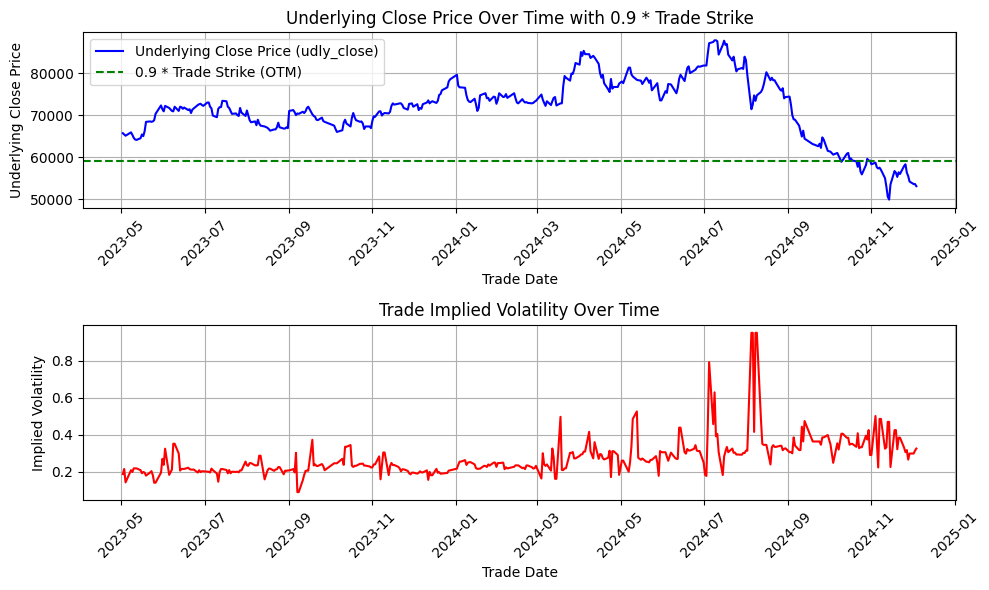

In [330]:
# Set the constant value for OTM strike
otm_strike

# Convert 'trade_date' to datetime format
unique_trade_data2['trade_date'] = pd.to_datetime(unique_trade_data2['trade_date'])

# Plotting udly_close over trade_date
plt.figure(figsize=(10, 6))

# Plot for underlying close price and constant OTM strike
plt.subplot(2, 1, 1)  # Two rows, one column, first plot
plt.plot(unique_trade_data2['trade_date'], unique_trade_data2['udly_close'], label='Underlying Close Price (udly_close)', color='b')
plt.axhline(otm_strike, label='0.9 * Trade Strike (OTM)', color='g', linestyle='--')
plt.xlabel('Trade Date')
plt.ylabel('Underlying Close Price')
plt.title('Underlying Close Price Over Time with 0.9 * Trade Strike')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

# Plotting trade_imvol over trade_date
plt.subplot(2, 1, 2)  # Two rows, one column, second plot
plt.plot(unique_trade_data2['trade_date'], unique_trade_data2['trade_imvol'], label='Trade Implied Volatility (trade_imvol)', color='r')
plt.xlabel('Trade Date')
plt.ylabel('Implied Volatility')
plt.title('Trade Implied Volatility Over Time')
plt.grid(True)
plt.xticks(rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


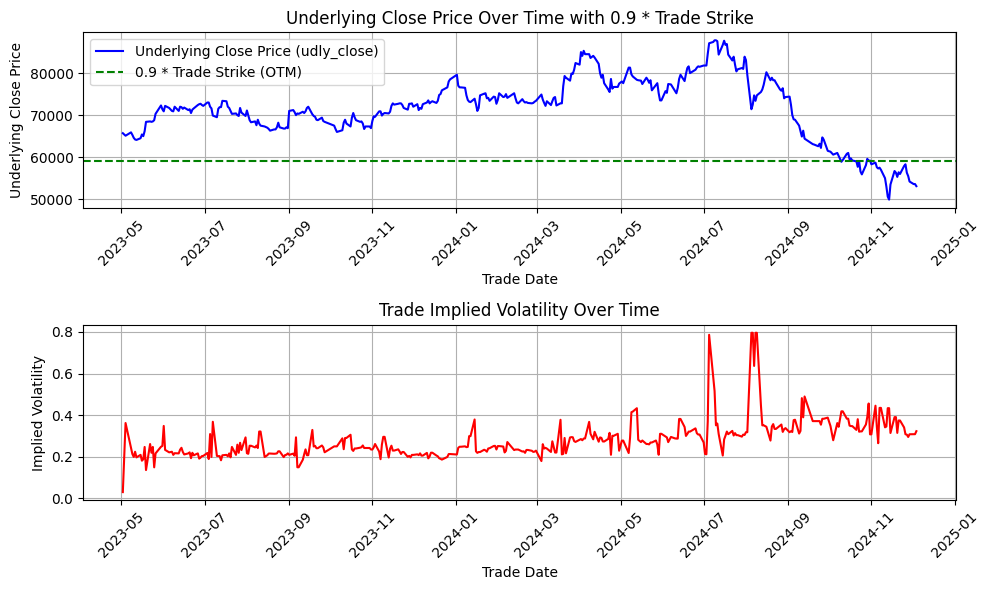

In [331]:
# Set the constant value for OTM strike
otm_strike

# Convert 'trade_date' to datetime format
unique_trade_data1['trade_date'] = pd.to_datetime(unique_trade_data1['trade_date'])

# Plotting udly_close over trade_date
plt.figure(figsize=(10, 6))

# Plot for underlying close price and constant OTM strike
plt.subplot(2, 1, 1)  # Two rows, one column, first plot
plt.plot(unique_trade_data1['trade_date'], unique_trade_data1['udly_close'], label='Underlying Close Price (udly_close)', color='b')
plt.axhline(otm_strike, label='0.9 * Trade Strike (OTM)', color='g', linestyle='--')
plt.xlabel('Trade Date')
plt.ylabel('Underlying Close Price')
plt.title('Underlying Close Price Over Time with 0.9 * Trade Strike')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

# Plotting trade_imvol over trade_date
plt.subplot(2, 1, 2)  # Two rows, one column, second plot
plt.plot(unique_trade_data1['trade_date'], unique_trade_data1['trade_imvol'], label='Trade Implied Volatility (trade_imvol)', color='r')
plt.xlabel('Trade Date')
plt.ylabel('Implied Volatility')
plt.title('Trade Implied Volatility Over Time')
plt.grid(True)
plt.xticks(rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

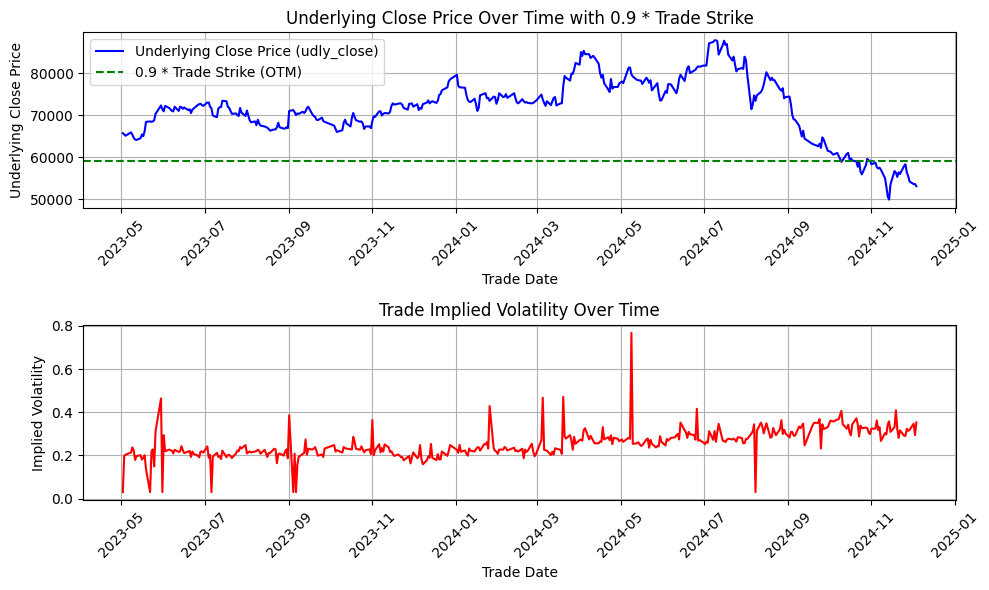

In [332]:
# Set the constant value for OTM strike
otm_strike

# Convert 'trade_date' to datetime format
unique_trade_data3['trade_date'] = pd.to_datetime(unique_trade_data3['trade_date'])

# Plotting udly_close over trade_date
plt.figure(figsize=(10, 6))

# Plot for underlying close price and constant OTM strike
plt.subplot(2, 1, 1)  # Two rows, one column, first plot
plt.plot(unique_trade_data3['trade_date'], unique_trade_data3['udly_close'], label='Underlying Close Price (udly_close)', color='b')
plt.axhline(otm_strike, label='0.9 * Trade Strike (OTM)', color='g', linestyle='--')
plt.xlabel('Trade Date')
plt.ylabel('Underlying Close Price')
plt.title('Underlying Close Price Over Time with 0.9 * Trade Strike')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

# Plotting trade_imvol over trade_date
plt.subplot(2, 1, 2)  # Two rows, one column, second plot
plt.plot(unique_trade_data3['trade_date'], unique_trade_data3['trade_imvol'], label='Trade Implied Volatility (trade_imvol)', color='r')
plt.xlabel('Trade Date')
plt.ylabel('Implied Volatility')
plt.title('Trade Implied Volatility Over Time')
plt.grid(True)
plt.xticks(rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [333]:
S_paths = unique_trade_data1['trade_imvol'].values
S_paths[0]

0.03

In [334]:
# 시뮬레이션 실행
results = dynamic_hedging_simulation_updated(unique_trade_data3, X, r, q, T, shares_per_call, flag)
results


,Final Stock Price,Strike Price,Theoretical Price,Hedging Cost,PnL,ATM Case,ITM Case,OTM Case,Performance,Cumulative_error
0,53100,59130,7.740852e+08,1.096397e+09,-3.223122e+08,False,False,True,1228.93,-38.97


In [335]:
# 시뮬레이션 실행 (개별적으로 실행)
results1 = dynamic_hedging_simulation_updated(unique_trade_data1, X, r, q, T, shares_per_call, flag)
results2 = dynamic_hedging_simulation_updated(unique_trade_data2, X, r, q, T, shares_per_call, flag)
results3 = dynamic_hedging_simulation_updated(unique_trade_data3, X, r, q, T, shares_per_call, flag)

# 결과들을 합치기
final_results = pd.concat([results1, results2, results3], ignore_index=True)
final_results

,Final Stock Price,Strike Price,Theoretical Price,Hedging Cost,PnL,ATM Case,ITM Case,OTM Case,Performance,Cumulative_error
0,53100,59130,7.740852e+08,1.202964e+09,-4.288786e+08,False,False,True,1136.62,-50.51
1,53100,59130,8.824010e+08,1.193642e+09,-3.112405e+08,False,False,True,1139.01,-52.06
2,53100,59130,7.740852e+08,1.096397e+09,-3.223122e+08,False,False,True,1228.93,-38.97


In [336]:
wanted_cols = ['Hedging Cost', 'PnL']

final_results[wanted_cols].to_pickle(OUTPUT_PATH / 'pkh' / f'hc_pnl_{start_date_str}.pkl')

----------------------------------------------------------------------------------

### 실현변동성이 Given 40%가 아니라면? 

1. Heston 모델의 주가 경로와 변동성 경로 생성
2. Heston 모델에서 델타는 주가 뿐만 아니라 변동성의 영향을 받음 (변동성을 동적으로 반영한 델타 계산)
3. Heston 모델은 특히 ATM 옵션의 높은 감마(Gamma)로 인한 성과 불안정을 개선할 가능성이 큼
4. 필요 이상의 헷징 거래를 줄이는 효과
5. PnL 변동성 감소와 함께 헷징 비용 절감이 가능
6. 변동성 군집과 평균회귀, 주가와 변동성 간의 상관관계, Vol Skew, Fat tail 반영

Stochastic Vol path 및 Heston Model을 이용한 헷지

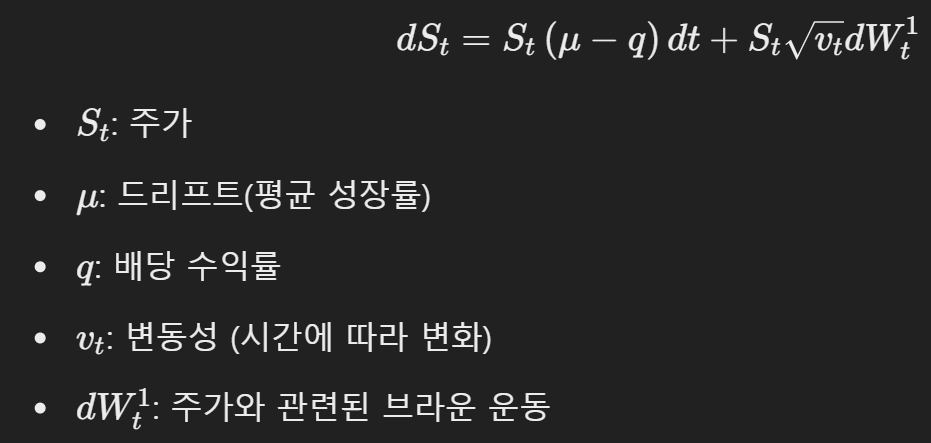
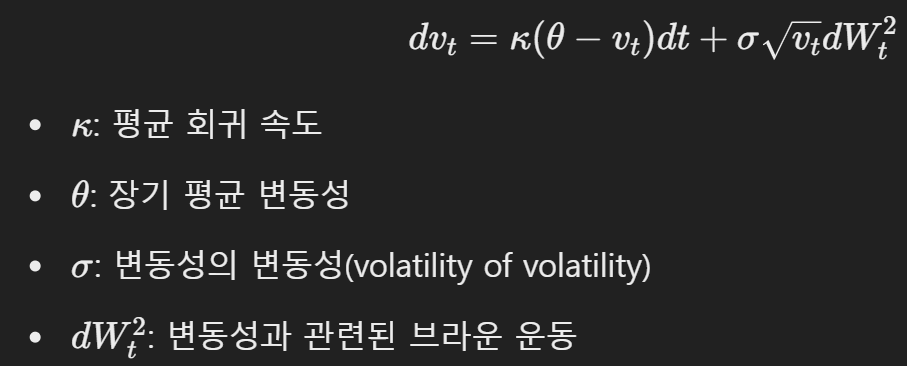
![image-3.png](attachment:image-3.png)

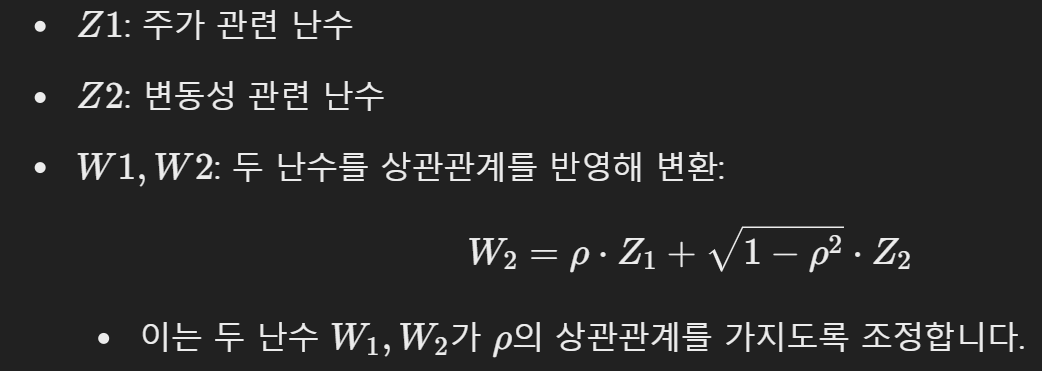

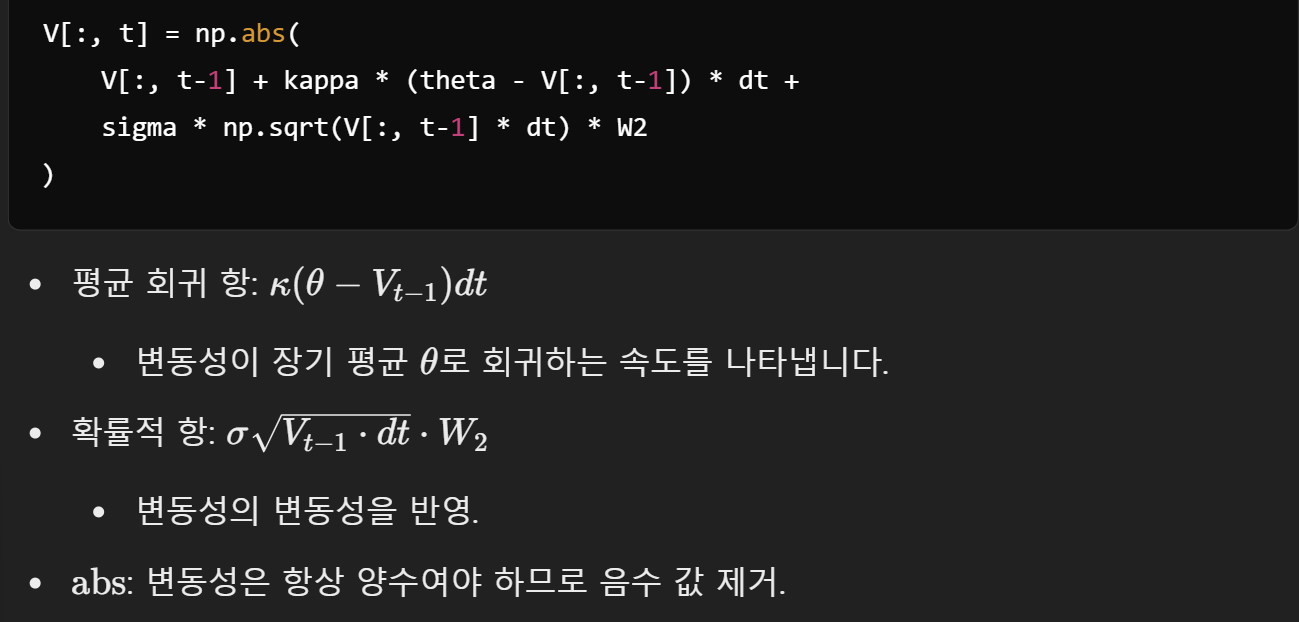
절대값을 씌우는 과정에서 오류가 발생

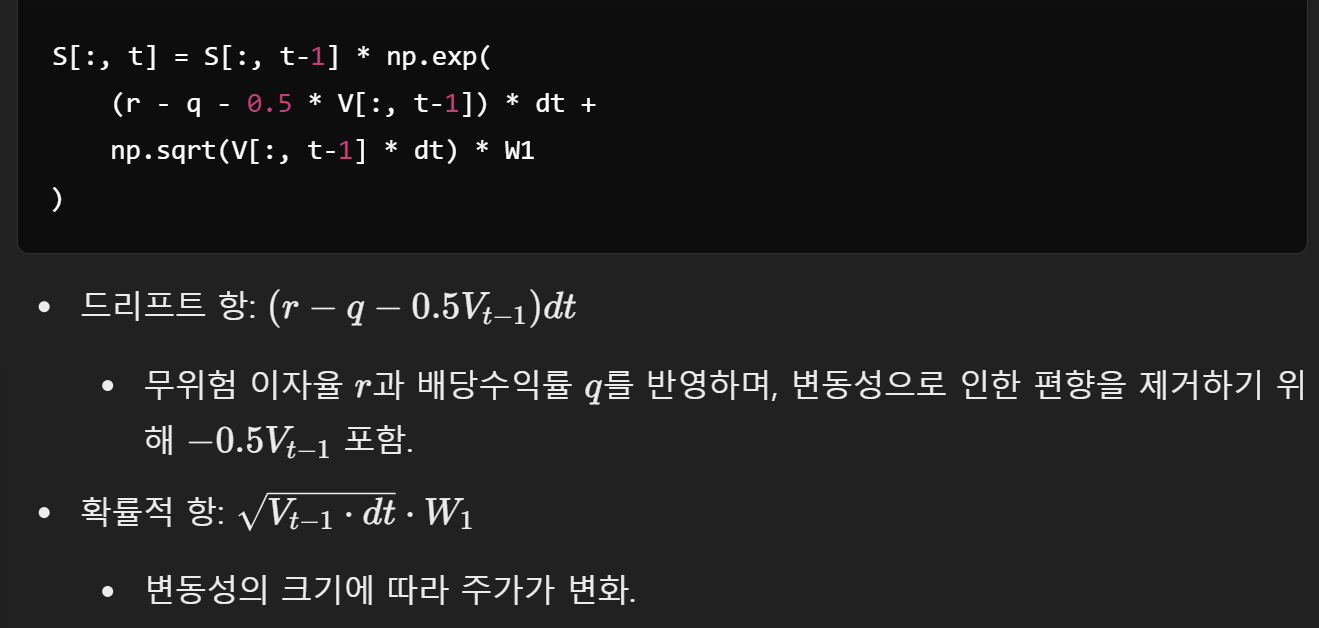

![image.png](attachment:image.png)

In [337]:
from scipy.stats import norm

# Heston 모델을 통한 주가 및 변동성 경로 시뮬레이션
def simulate_heston_paths(S0, v0, r, q, T, dt, kappa, theta, sigma, rho, nsim):
    """
    Heston 모델을 기반으로 주가 및 변동성 경로 시뮬레이션.
    """
    nsteps = int(T / dt)
    S = np.zeros((nsim, nsteps + 1))
    V = np.zeros((nsim, nsteps + 1))
    S[:, 0] = S0
    V[:, 0] = v0

    for t in range(1, nsteps + 1):
        Z1 = np.random.normal(size=nsim)
        Z2 = np.random.normal(size=nsim)
        W1 = Z1
        W2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2

        V[:, t] = np.abs(
            V[:, t-1] + kappa * (theta - V[:, t-1]) * dt +
            sigma * np.sqrt(V[:, t-1] * dt) * W2
        )
        S[:, t] = S[:, t-1] * np.exp(
            (r - q - 0.5 * V[:, t-1]) * dt +
            np.sqrt(V[:, t-1] * dt) * W1
        )

    return S, V

# Heston 델타 계산
def heston_delta(S, X, r, q, t, sigma_path, flag):
    """
    동적 변동성을 기반으로 Heston 델타 계산.
    """
    d1 = (np.log(S / X) + (r - q + 0.5 * sigma_path**2) * t) / (sigma_path * np.sqrt(t))
    return norm.cdf(d1) if flag.lower() == 'call' else norm.cdf(d1) - 1

# Heston 기반 헤징 성과 분석 함수
def simulate_and_calculate_hedging_cost_heston(S, X, r, q, kappa, theta, sigma, rho, T, nsim, interval, flag, shares_per_call):
    dt = interval / 365  # 리밸런싱 간격 (연 단위)
    m = int(T / dt) + 1  # 리밸런싱 스텝 수

    # Heston 모델로 주가 및 변동성 경로 생성
    S_paths, V_paths = simulate_heston_paths(S, 0.04, r, q, T, dt, kappa, theta, sigma, rho, nsim)

    # 잔여 시간 계산
    time_to_maturity = T - np.arange(m) * dt
    time_to_maturity = np.maximum(0, time_to_maturity)  # 음수 방지

    # 델타 계산 (전체 경로에서 동적 변동성 적용)
    deltas = heston_delta(S_paths[:, :-1], X, r, q, time_to_maturity[:-1], np.sqrt(V_paths[:, :-1]), flag)
    deltas = np.hstack((deltas, np.where(S_paths[:, -1:] >= X, 1.0, 0.0)))

    # Delta 차이 계산 및 주식 매수/매도
    delta_diff = np.diff(np.hstack((np.zeros((nsim, 1)), deltas)), axis=1)
    shares_purchased = delta_diff * shares_per_call

    # 매수/매도 비용 계산
    cost_of_shares = shares_purchased * S_paths

    # 거래 비용 계산
    transaction_costs = np.where(cost_of_shares < 0, np.abs(cost_of_shares) * 0.001, 0)

    # 누적 비용 계산
    cumulative_costs = np.cumsum(cost_of_shares, axis=1)
    interest_costs = np.zeros_like(cumulative_costs)
    interest_costs[:, :-1] = cumulative_costs[:, :-1] * (np.exp(r * dt) - 1)
    cumulative_costs[:, 1:] += np.cumsum(interest_costs[:, :-1], axis=1)

    # 최종 비용 계산
    final_cost = cumulative_costs[:, -1]
    hedge_cost = np.where(S_paths[:, -1] > X, final_cost - X * shares_per_call, final_cost)
    hedge_cost_with_transaction = hedge_cost + np.sum(transaction_costs, axis=1)

    # Moneyness 비교 (ITM, ATM, OTM)
    atm_case = hedge_cost_with_transaction[(S_paths[:, -1] < 1.01 * X) & (S_paths[:, -1] > 0.99 * X)]
    itm_case = hedge_cost_with_transaction[S_paths[:, -1] > X]
    otm_case = hedge_cost_with_transaction[S_paths[:, -1] < X]

    # PnL 계산
    theoretical_price = bsprice(S, X, r, q, T, imvol, flag)
    hedging_pnl = theoretical_price * shares_per_call - hedge_cost_with_transaction

    # 통계 계산
    mean_hedging_cost = np.mean(hedge_cost)
    performance_msr = np.std(hedge_cost - theoretical_price) / np.mean(theoretical_price)
    mean_hedging_cost_tr = np.mean(hedge_cost_with_transaction)
    performance_msr_tr = np.std(hedge_cost_with_transaction) / np.mean(theoretical_price)
    mean_pnl = np.mean(hedging_pnl)

    df_results = pd.DataFrame({
        "Stock Price": S_paths[:, -1],
        "Hedge Cost": hedge_cost,
        "Hedge Cost with Transaction": hedge_cost_with_transaction,
        "PnL": hedging_pnl,
    })

    return (
        mean_hedging_cost,
        performance_msr,
        mean_hedging_cost_tr,
        performance_msr_tr,
        itm_case,
        otm_case,
        atm_case,
        mean_pnl,
        hedging_pnl,
        S_paths,
        df_results
    )


보통 Heston 모델의 파라미터는 캘리브레이션을 통해 얻지만, 우선 S&P 500의 파라미터와 우리가 가정한 장기변동성 40%를 이용하기로 가정함

In [338]:
# Parameters
S = 50
X = 55
r = 0.04
q = 0
imvol = 0.46
T = 0.5  # 6개월
# S&P 500 옵션 파라미터 "Adaptive calibration of Heston Model using PCRLB based switching Filter (2021)""
kappa = 2.0 # 변동성 평균 회귀 속도
theta = 0.16 # 해당 논문에서는 0.01 이지만, 40% 변동성을 가정하기 위해 장기 변동성의 루트인 theta를 0.16으로 설정정
sigma = 0.2 # 변동성의 변동성
rho = -0.5 # 주가와 변동성 간의 상관관계
nsim = 1000
interval = 1  # 하루 단위 리밸런싱
flag = "call"
shares_per_call = 100_000


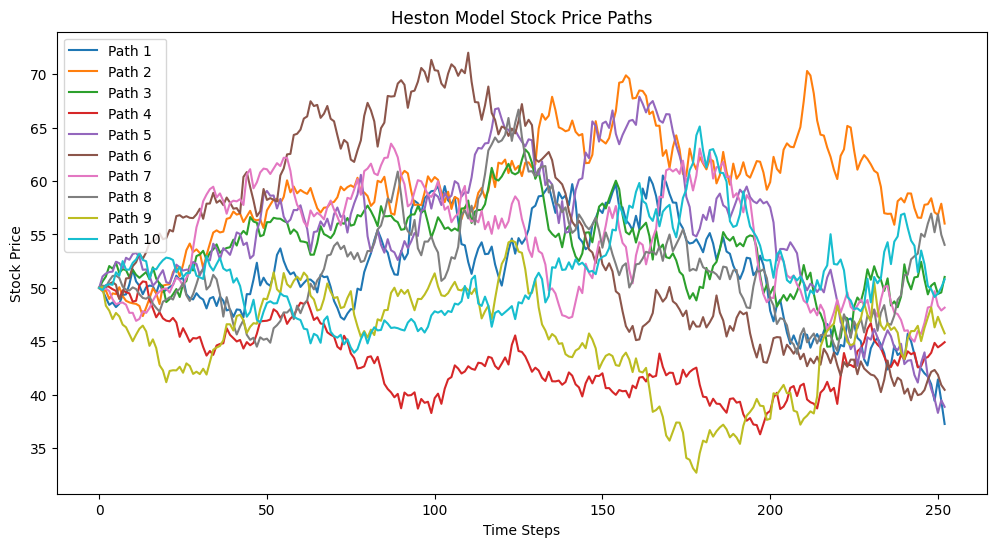

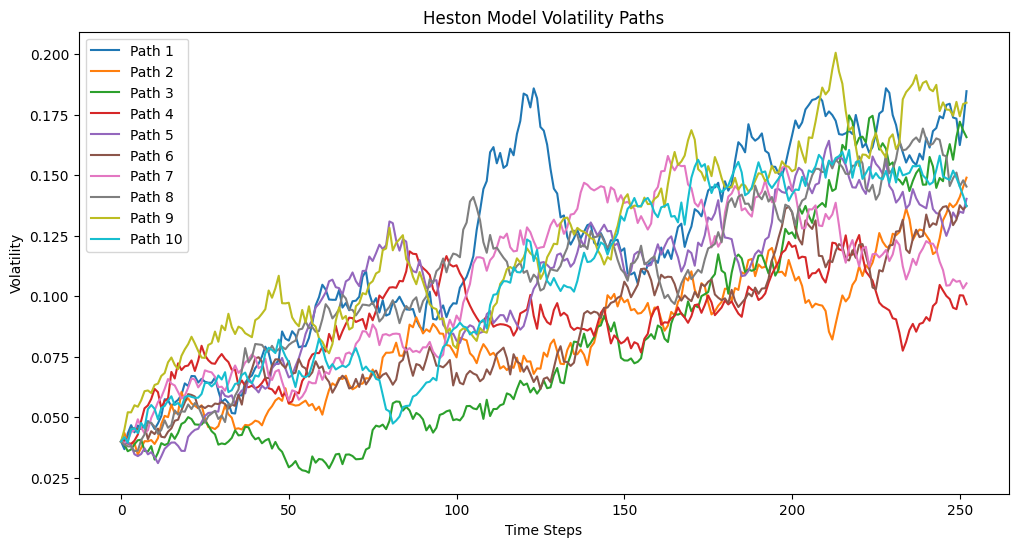

In [339]:
# Heston 시뮬레이션 실행
S_paths, V_paths = simulate_heston_paths(S0=50, v0=0.04, r=0.04, q=0, T=1, dt=1/252, kappa=2.0, theta=0.16, sigma=0.2, rho=-0.5, nsim=10)

# 주가 경로 시각화
plt.figure(figsize=(12, 6))
for i in range(10):  # 10개의 경로만 그리기
    plt.plot(S_paths[i], label=f'Path {i+1}')
plt.title('Heston Model Stock Price Paths')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# 변동성 경로 시각화
plt.figure(figsize=(12, 6))
for i in range(10):  # 10개의 경로만 그리기
    plt.plot(V_paths[i], label=f'Path {i+1}')
plt.title('Heston Model Volatility Paths')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.legend()
plt.show()


Stochastic Vol Path에서의 변동성 40%를 가정한 BSM 모델 기반 헷지

In [340]:
def simulate_and_calculate_hedging_cost_gbm(S, X, r, q, sigma, T, nsim, interval, flag, shares_per_call, S_paths):
    """
    GBM(40% 변동성) 기반으로 주어진 주가 경로에서 헷징 성과를 계산.
    """
    dt = interval / 365  # 리밸런싱 간격 (연 단위)
    m = int(T / dt) + 1  # 리밸런싱 스텝 수

    # 잔여 시간 계산
    time_to_maturity = T - np.arange(m) * dt
    time_to_maturity = np.maximum(0, time_to_maturity)  # 음수 방지

    # GBM 기준 델타 계산
    deltas = delta(S_paths[:, :-1], X, r, q, time_to_maturity[:-1], sigma, flag)
    deltas = np.hstack((deltas, np.where(S_paths[:, -1:] >= X, 1.0, 0.0)))

    # Delta 차이 계산 및 주식 매수/매도
    delta_diff = np.diff(np.hstack((np.zeros((nsim, 1)), deltas)), axis=1)
    shares_purchased = delta_diff * shares_per_call

    # 매수/매도 비용 계산
    cost_of_shares = shares_purchased * S_paths

    # 거래 비용 계산
    transaction_costs = np.where(cost_of_shares < 0, np.abs(cost_of_shares) * 0.001, 0)

    # 누적 비용 계산
    cumulative_costs = np.cumsum(cost_of_shares, axis=1)
    interest_costs = np.zeros_like(cumulative_costs)
    interest_costs[:, :-1] = cumulative_costs[:, :-1] * (np.exp(r * dt) - 1)
    cumulative_costs[:, 1:] += np.cumsum(interest_costs[:, :-1], axis=1)

    # 최종 비용 계산
    final_cost = cumulative_costs[:, -1]
    hedge_cost = np.where(S_paths[:, -1] > X, final_cost - X * shares_per_call, final_cost)
    hedge_cost_with_transaction = hedge_cost + np.sum(transaction_costs, axis=1)

    # Moneyness 비교 (ITM, ATM, OTM)
    atm_case = hedge_cost_with_transaction[(S_paths[:, -1] < 1.01 * X) & (S_paths[:, -1] > 0.99 * X)]
    itm_case = hedge_cost_with_transaction[S_paths[:, -1] > X]
    otm_case = hedge_cost_with_transaction[S_paths[:, -1] < X]

    # PnL 계산
    theoretical_price = bsprice(S, X, r, q, T, sigma, flag)
    hedging_pnl = theoretical_price * shares_per_call - hedge_cost_with_transaction

    # 통계 계산
    mean_hedging_cost = np.mean(hedge_cost)
    performance_msr = np.std(hedge_cost - theoretical_price) / np.mean(theoretical_price)
    mean_hedging_cost_tr = np.mean(hedge_cost_with_transaction)
    performance_msr_tr = np.std(hedge_cost_with_transaction) / np.mean(theoretical_price)
    mean_pnl = np.mean(hedging_pnl)

    return {
        "mean_hedging_cost": mean_hedging_cost,
        "performance_msr": performance_msr,
        "mean_hedging_cost_tr": mean_hedging_cost_tr,
        "performance_msr_tr": performance_msr_tr,
        "mean_pnl": mean_pnl,
        "std_pnl": np.std(hedging_pnl),
        "relative_error": (np.std(hedging_pnl) / (theoretical_price * shares_per_call)) * 100,
        "atm_case": atm_case,
        "itm_case": itm_case,
        "otm_case": otm_case,
        "hedging_pnl": hedging_pnl
    }


In [341]:
heston_df = simulate_and_calculate_hedging_cost_heston(S, X, r, q, kappa, theta, sigma, rho, T, nsim, interval, flag, shares_per_call)[-1]
heston_df

,Stock Price,Hedge Cost,Hedge Cost with Transaction,PnL
0,50.350271,275613.161819,290833.217797,202596.544104
1,47.996657,175288.214217,187437.669273,305992.092627
2,46.758075,269378.368417,281644.314189,211785.447712
3,60.531076,288040.265886,304031.472123,189398.289778
4,40.260557,259249.381469,267670.908971,225758.852930
...,...,...,...,...
995,43.935162,322249.446130,332839.242083,160590.519818
996,63.207298,262135.166477,272621.476946,220808.284955
997,54.209231,225657.106375,240650.142608,252779.619293
998,42.430090,226175.181254,234849.076336,258580.685565


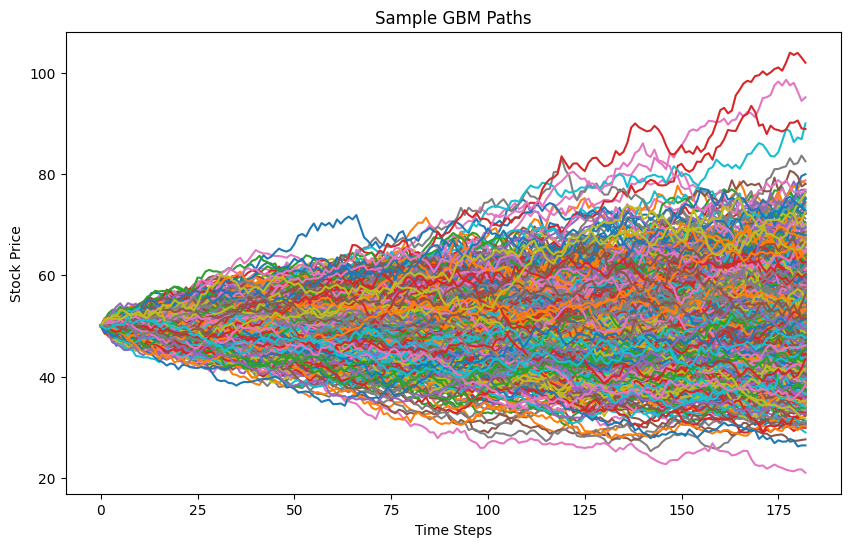

In [342]:
stock_paths = simulate_and_calculate_hedging_cost_heston(S, X, r, q, kappa, theta, sigma, rho, T, nsim, interval, flag, shares_per_call)[9]

plt.figure(figsize=(10, 6))
for i in range(1000):
    plt.plot(stock_paths[i])
plt.title('Sample GBM Paths')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

Mean PNL: 232704.61
Standard Deviation of PNL: 48940.19
Performance meaure: 9.92%


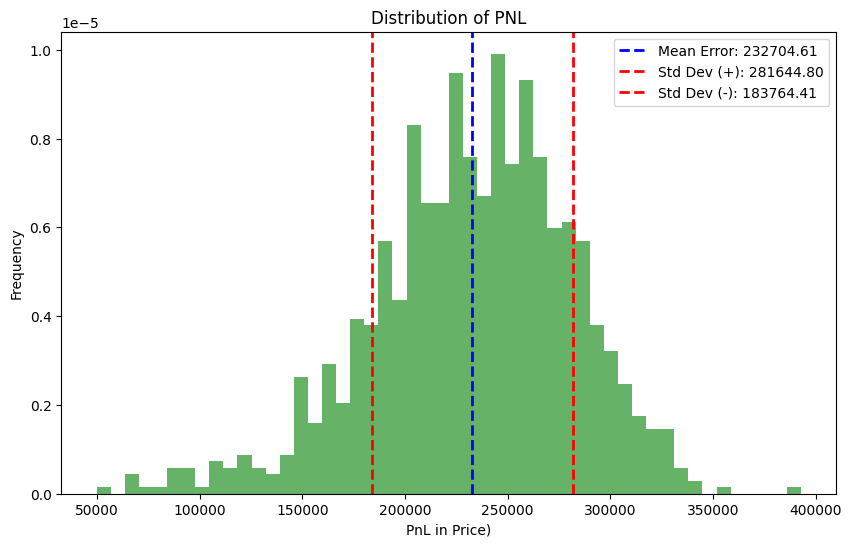

In [343]:
# 시뮬레이션 실행
results = simulate_and_calculate_hedging_cost_heston(S, X, r, q, kappa, theta, sigma, rho, T, nsim, interval, flag, shares_per_call)
mean_hedging_cost, performance_msr, mean_hedging_cost_tr, performance_msr_tr, _, _, _, mean_pnl, hedging_pnl, _ , _= results

theoretical_price = bsprice(S, X, r, q, T, imvol, flag)

# 5. Hedging Error 분석
std_error = np.std(hedging_pnl)  # PnL의 표준 편차
mean_error = np.mean(hedging_pnl)  # PnL의 평균

print(f"Mean PNL: {mean_error:.2f}")
print(f"Standard Deviation of PNL: {std_error:.2f}")

# 6. Relative Hedging Error 계산
option_premium = theoretical_price * shares_per_call  # 옵션 프리미엄
relative_std_error = (std_error / option_premium) * 100  # 상대 표준 편차

print(f"Performance meaure: {relative_std_error:.2f}%")

# PnL 가격 범위를 지정하여 히스토그램 생성
plt.figure(figsize=(10, 6))
plt.hist(hedging_pnl, bins=50, density=True, alpha=0.6, color='g', range=(np.min(hedging_pnl), np.max(hedging_pnl)))
plt.title('Distribution of PNL')
plt.xlabel('PnL in Price)')
plt.ylabel('Frequency')

# 평균과 표준 편차를 표시
plt.axvline(mean_error, color='blue', linestyle='dashed', linewidth=2, label=f'Mean Error: {mean_error:.2f}')
plt.axvline(mean_error + std_error, color='red', linestyle='dashed', linewidth=2, label=f'Std Dev (+): {mean_error + std_error:.2f}')
plt.axvline(mean_error - std_error, color='red', linestyle='dashed', linewidth=2, label=f'Std Dev (-): {mean_error - std_error:.2f}')
plt.legend()
plt.show()

### Heston vs. BSM

Heston 모델 헷징 결과:
Mean PnL: 232704.61
Standard Deviation of PnL: 48940.19
Performance Measure (Relative Hedging Error): 9.92%

GBM (40%) 헷징 결과:
Mean PnL: 149045.23
Standard Deviation of PnL: 64784.82
Performance Measure (Relative Hedging Error): 15.83%


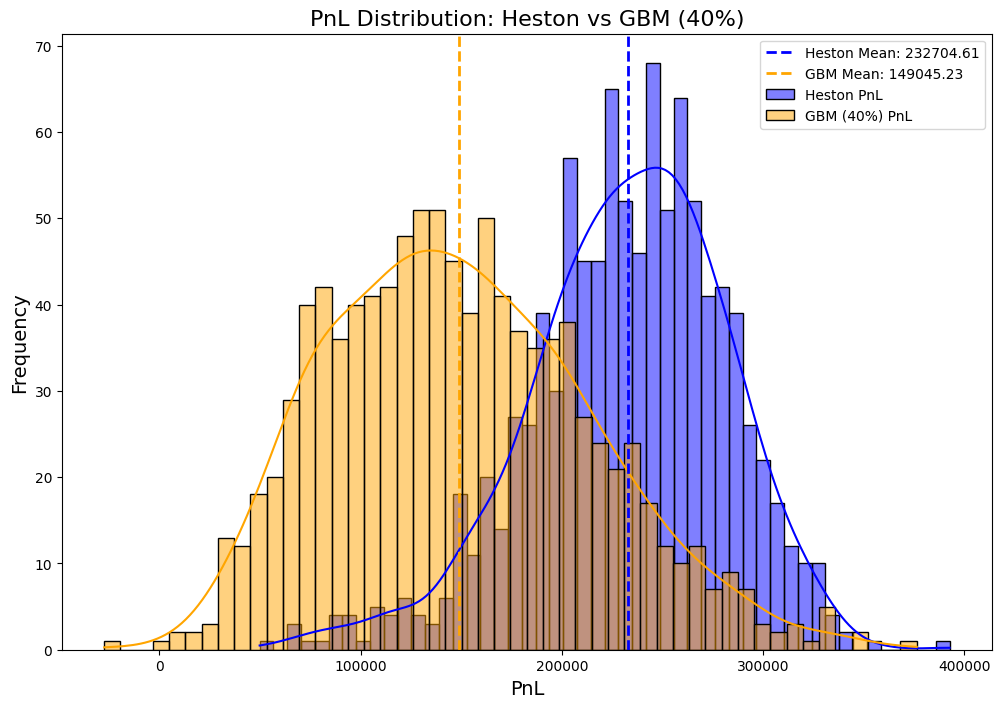

In [344]:
# GBM (40%) 헷징 성과 계산
gbm_results = simulate_and_calculate_hedging_cost_gbm(S, X, r, q, 0.4, T, nsim, interval, flag, shares_per_call, results[9])  # Heston 기반 주가 경로 사용

# 비교 결과 출력
print("Heston 모델 헷징 결과:")
print(f"Mean PnL: {mean_pnl:.2f}")
print(f"Standard Deviation of PnL: {std_error:.2f}")
print(f"Performance Measure (Relative Hedging Error): {relative_std_error:.2f}%")

print("\nGBM (40%) 헷징 결과:")
print(f"Mean PnL: {gbm_results['mean_pnl']:.2f}")
print(f"Standard Deviation of PnL: {gbm_results['std_pnl']:.2f}")
print(f"Performance Measure (Relative Hedging Error): {gbm_results['relative_error']:.2f}%")

# PnL 비교 히스토그램
plt.figure(figsize=(12, 8))
sns.histplot(hedging_pnl, bins=50, color='blue', alpha=0.5, label='Heston PnL', kde=True)
sns.histplot(gbm_results["hedging_pnl"], bins=50, color='orange', alpha=0.5, label='GBM (40%) PnL', kde=True)

plt.title("PnL Distribution: Heston vs GBM (40%)", size=16)
plt.xlabel("PnL", size=14)
plt.ylabel("Frequency", size=14)
plt.axvline(mean_pnl, color='blue', linestyle='dashed', linewidth=2, label=f'Heston Mean: {mean_pnl:.2f}')
plt.axvline(gbm_results['mean_pnl'], color='orange', linestyle='dashed', linewidth=2, label=f'GBM Mean: {gbm_results["mean_pnl"]:.2f}')
plt.legend()
plt.show()


결과분석:
1. Heston의 PNL이 훨씬 높아서 더 효율적으로 헷지했음을 알 수 있음
2. 헤지 퍼포먼스 또한 더 낮기에, 안정적이고 효과적인 헷지라는 것을 관측
3. 분포가 더 오른쪽으로 치우쳐져 있고, 분포가 더 좁고 날카로움 -> 헷징 성과가 안정적이고 예측가능함.

But, 내 마음대로 theta 파라미터를 정했음

In [345]:
# Kospi200_data = pd.read_csv('Kospi200_2019-2023.csv')

In [346]:
# Kospi200_data

### 2023.06.30-2023.12.31 10% OTM 옵션 매도 포지션 Delta Hedging